<a href="https://colab.research.google.com/github/eshraongithub/DengAI-Predicting-Disease-Spread-ES/blob/main/3_DengAI_Predicting_Disease_Spread_Optimizaci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  La situación de partida

Partimos de un modelo de un trabajo de predicción de un problema de regresión de la actividad 2 con mejor MAE de 26.8 usando un modelo de regresión lineal. El objetivo de esta actividad es mejorar los resultados de predicción que se han obtenido en la actividad 2 mediante métodos de ensemble como el boosting y la optimización de la parametrización de los algoritmos utilizados previamente.


# Setting Preliminares

Antes de empezar cualquier análisis hay que asegurar que las librerías básicas y de uso general (numpy, pandas, etc.) están correctamente importadas. 

In [ ]:
# carga de datos
import pandas as pd
import io
from google.colab import files
# manipulación y visualización
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns

# Carga de Datos

Cargamos los datos dentro del entorno con las funcionalidades que nos permite Google Colab

In [ ]:
def upload_files ():
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')))
    return df

Subimos los datos de entrenamiento/features (dengue_features_train)


In [ ]:
train_feat = upload_files()
train_feat.head()

Saving dengue_features_train.csv to dengue_features_train.csv
User uploaded file "dengue_features_train.csv" with length 287139 bytes


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [ ]:
train_feat.shape

(1456, 24)

Posteriormente subimos los datos que únicamente nos proporcionan el número de casos de dengue para las semanas de entrenamiento (dengue_labels_train)

In [ ]:
train_labels = upload_files()
train_labels.head()

Saving dengue_labels_train.csv to dengue_labels_train.csv
User uploaded file "dengue_labels_train.csv" with length 19582 bytes


,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


Mezclamos los dos conjuntos de datos para tenerlos en un único dataframe

In [ ]:
train = pd.merge(train_feat,train_labels,on=['city', 'year', 'weekofyear'])

train.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


Subimos los datos de test para generar la evaluación final (dengue_features_test)

In [ ]:
test = upload_files()
test.head()

Saving dengue_features_test.csv to dengue_features_test.csv
User uploaded file "dengue_features_test.csv" with length 82465 bytes


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,296.4,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,296.7,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,296.4,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,303.0,296.9,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,294.760000,302.3,297.3,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


# Preproceso

Procedemos con las funciones y transformaciones que permitieran el uso de las variables en los siguientes clasificadores, por ejemplo la transformación de las variables categóricas en numéricas, etc.

In [ ]:
train.drop("week_start_date", axis = 1, inplace = True)
test.drop("week_start_date", axis = 1, inplace = True)
train.head()

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


Trataremos los valores perdidos que los hay dado que nos evitarían tener un modelo de los datos que tenemos.

In [ ]:
pd.isnull(train).any()

city                                     False
year                                     False
weekofyear                               False
ndvi_ne                                   True
ndvi_nw                                   True
ndvi_se                                   True
ndvi_sw                                   True
precipitation_amt_mm                      True
reanalysis_air_temp_k                     True
reanalysis_avg_temp_k                     True
reanalysis_dew_point_temp_k               True
reanalysis_max_air_temp_k                 True
reanalysis_min_air_temp_k                 True
reanalysis_precip_amt_kg_per_m2           True
reanalysis_relative_humidity_percent      True
reanalysis_sat_precip_amt_mm              True
reanalysis_specific_humidity_g_per_kg     True
reanalysis_tdtr_k                         True
station_avg_temp_c                        True
station_diur_temp_rng_c                   True
station_max_temp_c                        True
station_min_t

Quitamos cualquier observación que tenga un valor nulo.

In [ ]:
train.dropna(how='any', axis=0, inplace=True)

Y aplicamos lo mismo para los datos de test

In [ ]:
test.fillna(method='ffill', inplace=True)
pd.isnull(test).any()

city                                     False
year                                     False
weekofyear                               False
ndvi_ne                                  False
ndvi_nw                                  False
ndvi_se                                  False
ndvi_sw                                  False
precipitation_amt_mm                     False
reanalysis_air_temp_k                    False
reanalysis_avg_temp_k                    False
reanalysis_dew_point_temp_k              False
reanalysis_max_air_temp_k                False
reanalysis_min_air_temp_k                False
reanalysis_precip_amt_kg_per_m2          False
reanalysis_relative_humidity_percent     False
reanalysis_sat_precip_amt_mm             False
reanalysis_specific_humidity_g_per_kg    False
reanalysis_tdtr_k                        False
station_avg_temp_c                       False
station_diur_temp_rng_c                  False
station_max_temp_c                       False
station_min_t

También tenemos que transformar nuestras variables categóricas, en este caso una única variable que es la ciudad para lo que vamos a utilizar un *binarizador* para train y para test

In [ ]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
train['city_bin'] = lb.fit_transform(train['city'])
test['city_bin'] = lb.fit_transform(test['city'])

Quitamos la columna "city" en ambos dataframes

In [ ]:
train.drop("city", axis = 1, inplace = True)
test.drop("city", axis = 1, inplace = True)

# Boosting

Vamos a usar un gradient boosting regressor para predecir el número de casos y para ello vamos a instanciar un gradient boosting regressor con los parámetros max_depth igual a 4 y n_estimators igual a 200, entrenar el regressor después de dividir el conjunto de datos en 80% para train y 20% para test, y evaluar el RMSE usando el conjunto de datos de test.

In [ ]:
# Import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

# Instantiate gb
gb = GradientBoostingRegressor(n_estimators=200, max_depth=4,
random_state=2)

# Create feature and target arrays
X = train.drop('total_cases', axis=1)
y = train['total_cases']

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

# Fit gb to the training set
gb.fit(X_train, y_train)

# Predict test set labels
y_pred = gb.predict(X_test)

# Import mean_squared_error as MSE
from sklearn.metrics import mean_squared_error as MSE

# Compute MSE
mse_test = MSE(y_test, y_pred)

# Compute RMSE
rmse_test = mse_test**(1/2)

# Print RMSE
print('Test set RMSE of gb: {:.3f}'.format(rmse_test))

Test set RMSE of gb: 19.078


*Usando el Gradient Boosting regressor conseguimos un MAE de 26.1.*

# Stochastic Gradient Boosting (SGB)

Vamos a tratar de resolver este problema de regresión usando el Stochastic Gradient Boosting. Iniciamos una intancia de SGB, entrenamos el SGB regressor sobre los datos de train, predecimos los labels de test y evaluamos el SGB regressor sacando su RMSE usando los datos de test.

In [ ]:
# Import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Instantiate sgbr
sgbr = GradientBoostingRegressor(max_depth=4, 
            subsample=0.9,
            max_features=0.75,
            n_estimators=200,                                
            random_state=2)

# Fit sgbr to the training set
sgbr.fit(X_train, y_train)

# Predict test set labels
y_pred = sgbr.predict(X_test)

# Compute test set MSE
mse_test = MSE(y_test, y_pred)

# Compute test set RMSE
rmse_test = mse_test**(1/2)

# Print rmse_test
print('Test set RMSE of sgbr: {:.3f}'.format(rmse_test))

Test set RMSE of sgbr: 20.936


El stochastic gradient boosting regressor logra un RMSE ligeramente más bajo sobre los datos de test en comparación con el gradient boosting regressor (que genera un RMSE de 30).

# Hyperparameter Tuning

### Los hiperparámetros de un modelo de Machine Learning son parámetros que no se aprenden de los datos. Deben establecerse antes de ajustar el modelo al conjunto de entrenamiento. Trabajaremos en ajustar los hiperparámetros de un modelo basado en árboles utilizando la validación cruzada (grid search cross validation).

# Random forests hyperparameters

Vamos a crear un RandomForestRegressor y a mostrar y ajustar sus hiperparámetros. 

In [ ]:
# Import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

# Instantiate rf
rf = RandomForestRegressor(n_estimators=10,
            random_state=2)

rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 2,
 'verbose': 0,
 'warm_start': False}

Ahora, configuraremos manualmente el grid de hiperparámetros que se usarán para ajustar los hiperparámetros de rf y encontrar el regresor óptimo. Para ello, construiremos un grid de hiperparámetros y ajustaremos el número de estimators, el número máximo de características utilizadas al dividir cada nodo y el número mínimo de muestras por hoja.

In [ ]:
# Define the dictionary 'params_rf'
params_rf = {'n_estimators': [100, 350, 500],'max_features': ['log2', 'auto', 'sqrt'],'min_samples_leaf': [2, 10, 30]}

Ahora ejecutaremos el grid search. Realizaremos un grid search utilizando una validación cruzada=3 para encontrar los hiperparámetros óptimos de rf. Para evaluar cada modelo en el grid search, usaremos la métrica de negative mean squared error. Además, entrenaremos el objeto grid search (grid_rf) sobre los datos de train y evaluaremos el RMSE del mejor modelo sobre el conjunto de test.

In [ ]:
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

# Instantiate grid_rf
grid_rf = GridSearchCV(estimator=rf,
                       param_grid=params_rf,
                       scoring='neg_mean_squared_error',
                       cv=3,
                       verbose=1,
                       n_jobs=-1)

# Fit sgbr to the training set
grid_rf.fit(X_train, y_train)

# Extract the best estimator
best_model = grid_rf.best_estimator_

# Predict test set labels
y_pred = best_model.predict(X_test)

# Compute rmse_test
rmse_test = MSE(y_test, y_pred)**(1/2)

# Print rmse_test
print('Test RMSE of best model: {:.3f}'.format(rmse_test)) 

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  1.1min finished


Test RMSE of best model: 21.769


# Deep Learning

### Vamos a construir un modelo con Keras para ejecutar un modelo de red neuronal usando nuestro conjunto de datos y predicir el número de casos de Dengue.

Para comenzar, tomaremos el esqueleto de una red neuronal y agregaremos una capa oculta y una capa de salida. Luego, ajustaremos ese modelo y veremos a Keras hacer la optimización usando el "Adam" optimizer para que su modelo mejore continuamente. Usaremos la detención anticipada para detener la optimización cuando ya no ayude. Debido a que la optimización se detendrá automáticamente cuando ya no sea útil, es aceptable especificar el número máximo de epochs como 30. *Al principio del código configuramos la sesión para obtener resultados reproducibles.* Al final del código, mostraremos el valor MSE por epoch y vemos que obtenemos el mejor MSE después de 6 epochs. Experimentamos con el número de capas ocultas y el número de nodos y los ajustamos hasta llegar a la mejor precisión con el menor número de capas y nodos posible. Vamos a tratar de conseguir el error (MSE) más bajo usando el menor número de nodos posible para tratar de evitar que el modelo memorice los datos (overfitting), mejorar el rendimiento computacional y ahorrar tiempo de ejecución. Al final del código, guaradmos el mejor modelo como *best_model*.
Dentro del mismo código, comprobaremos si el modelo que construimos se beneficiaría de más datos de entrenamiento usando diferentes cantidades de datos de training. Los resultados muestran que nuestro modelo no se beneficiaría mucho de más datos de entrenamiento, ya que la precisión del conjunto de test sigue siendo plano a medidad que aumentamos la cantidad de datos usada en el model. Como siguiente paso, veremos las funciones de activación.

Loss function: mean_squared_error
Epoch 1/30
30/30 [==============================] - 0s 5ms/step - loss: 1608.8079 - mse: 1608.8079 - val_loss: 1137.4464 - val_mse: 1137.4464
Epoch 2/30
30/30 [==============================] - 0s 1ms/step - loss: 1273.4923 - mse: 1273.4923 - val_loss: 705.5911 - val_mse: 705.5911
Epoch 3/30
30/30 [==============================] - 0s 1ms/step - loss: 1225.4633 - mse: 1225.4633 - val_loss: 289.9078 - val_mse: 289.9078
Epoch 4/30
30/30 [==============================] - 0s 2ms/step - loss: 1157.1608 - mse: 1157.1608 - val_loss: 148.2921 - val_mse: 148.2921
Epoch 5/30
30/30 [==============================] - 0s 2ms/step - loss: 1116.2035 - mse: 1116.2035 - val_loss: 367.1495 - val_mse: 367.1495
Epoch 6/30
30/30 [==============================] - 0s 2ms/step - loss: 1100.9941 - mse: 1100.9941 - val_loss: 120.1356 - val_mse: 120.1356
Epoch 7/30
30/30 [==============================] - 0s 2ms/step - loss: 1100.4607 - mse: 1100.4607 - val_loss: 271.8073 - va

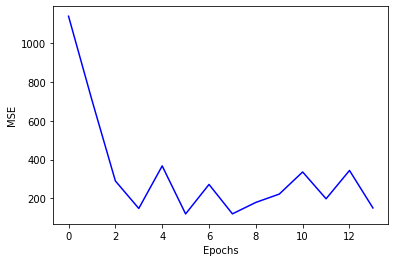

Epoch 1/50
4/4 [==============================] - 0s 3ms/step - loss: 699.4879 - mse: 699.4879
Epoch 2/50
4/4 [==============================] - 0s 3ms/step - loss: 727.4583 - mse: 727.4583
Epoch 3/50
4/4 [==============================] - 0s 2ms/step - loss: 688.8492 - mse: 688.8492
Epoch 4/50
4/4 [==============================] - 0s 2ms/step - loss: 669.8239 - mse: 669.8239
Epoch 5/50
4/4 [==============================] - 0s 2ms/step - loss: 680.4587 - mse: 680.4587
Epoch 6/50
8/8 [==============================] - 0s 2ms/step - loss: 954.7205 - mse: 954.7205
Epoch 1/50
16/16 [==============================] - 0s 2ms/step - loss: 1123.5438 - mse: 1123.5438
Epoch 2/50
16/16 [==============================] - 0s 2ms/step - loss: 1223.8215 - mse: 1223.8215
Epoch 3/50
8/8 [==============================] - 0s 2ms/step - loss: 951.4521 - mse: 951.4521
Epoch 1/50
28/28 [==============================] - 0s 1ms/step - loss: 920.2056 - mse: 920.2056
Epoch 2/50
28/28 [======================

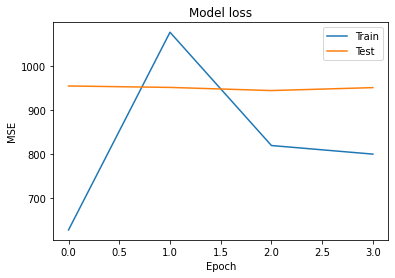

In [ ]:
# Setup repro section from Keras FAQ with TF1 to TF2 adjustments
import numpy as np
import tensorflow as tf
import random as rn

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                        inter_op_parallelism_threads=1)

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.compat.v1.set_random_seed(1234)

sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# Import necessary modules
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
import sklearn.metrics as metrics

# Import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping

# Create feature and target arrays
predictors = train.drop('total_cases', axis=1).values
target = train['total_cases']

# Save the number of columns in predictors: n_cols
n_cols = predictors.shape[1]

# Set up the model: model
model = Sequential()

# Add one hidden layer
model.add(Dense(90, activation='relu', input_shape=(n_cols,)))

# Add the output layer
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

# Define early_stopping_monitor
early_stop = EarlyStopping(monitor='mse', patience=2)

# Verify that model contains information from compiling
print("Loss function: " + model.loss)

# Fit the model
history = model.fit(predictors, target, validation_split=0.2, epochs=30, 
          callbacks = [early_stop])

# Create the plot
plt.plot(history.history['val_loss'], 'b')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

# Save the best model as best_model.hdf5
modelCheckpoint = ModelCheckpoint('best_model.hdf5', save_best_only = True)

# Visualise the loss and value loss
def plot_results(loss,val_loss):
  plt.figure()
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('Model loss')
  plt.ylabel('MSE')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper right')
  plt.show()

initial_weights = model.get_weights()

training_sizes = [125, 502, 879, 1255]

train_accs = []
test_accs = []

for size in training_sizes:
  	# Get a fraction of training data (we only care about the training data)
    X_train_frac, y_train_frac = X_train[:size], y_train[:size]

    # Reset the model to the initial weights and train it on the new training data fraction
    model.set_weights(initial_weights)
    model.fit(X_train_frac, y_train_frac, epochs = 50, callbacks = [early_stop])

    # Evaluate and store both: the training data fraction and the complete test set results
    train_accs.append(model.evaluate(X_train_frac, y_train_frac)[1])
    test_accs.append(model.evaluate(X_test, y_test)[1])
    
# Plot train vs test accuracies
plot_results(train_accs, test_accs)

*Conseguimos un MAE de 25.8 en el concurso usando el modelo anterior de Keras con 1 capa oculta y 1 neurona.*

# Predicción final

Generamos la predicción final usando el model de regresión lineal sobre los datos escalados de test del concurso usando solo las caracteristicas seleccionadas.

In [ ]:
final_pred = best_model.predict(test)
final_pred

array([ 4.7384373 ,  6.48860952,  6.43061349,  8.72646746,  7.84387619,
       10.47986429,  8.93022576, 11.26409048, 22.46514805, 17.65560317,
       17.17088651, 17.38327143, 30.81185123, 32.75474408, 52.04112937,
       61.2226381 , 49.60228983, 61.8030746 , 85.23992143, 82.66910952,
       62.75318413, 42.48214206, 36.59064134, 47.92416979, 44.3081373 ,
       35.59305   , 35.61808016, 39.59585635, 42.52910794, 34.07868968,
       32.14654683, 26.80090873, 20.98645556, 23.81713016, 16.46244206,
       15.3871619 , 14.87995635, 15.43164524, 12.08866746, 13.96179127,
       11.69701508, 12.43008124, 11.72959235, 12.38074762,  7.43123492,
        5.27433016,  5.44174444,  3.45651587,  5.12496667,  4.52042857,
        5.84519444,  7.27889206,  6.52152937,  5.43814841,  8.68291032,
        5.97975952, 12.22346587,  8.31175952, 10.25615548, 16.19571955,
       10.94716674, 22.77495476, 34.65165043, 33.44013413, 45.0926746 ,
       52.39784524, 55.3206373 , 51.66985794, 64.03113413, 68.86

La siguiente tarea es evaluar el rendimiento del modelo. Vamos a buscar  métricas disponibles en scikit-learn que le permitirán evaluar el desempeño de su modelo de una manera más matizada.

* Redondeamos el resultado

In [ ]:
# round the result and cast to int
import numpy as np
y = np.rint(final_pred) # round
y = y.astype(int) # cast to int
res = np.hstack(y)

res.shape

(416,)

In [ ]:
test.shape

(416, 23)

Volvemos a nombrar las ciudades en el dataset de "test"

In [ ]:
test["city_bin"].replace({1: "sj", 0: "iq"}, inplace=True)

* Generamos el fichero de salida

In [ ]:
# generate output
output = pd.DataFrame({ 'city': test['city_bin'], 'year': test['year'], 'weekofyear': test['weekofyear'], 
                       'total_cases': res})

from google.colab import files

with open('result.csv', 'w') as f:
  output.to_csv(f,  index = False)
  

files.download('result.csv')

output.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,city,year,weekofyear,total_cases
0,sj,2008,18,5
1,sj,2008,19,6
2,sj,2008,20,6
3,sj,2008,21,9
4,sj,2008,22,8


**Se adjunta junto a este notebook un pantallazo mostrando el usuario de DrivenData utilizado, los resultados obtenidos, y los datos del concurso utilizados en esta actividad**